In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from datetime import timedelta

In [10]:
# Loading in data
import pandas as pd
df = pd.read_csv('data/WMT.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5479 entries, 0 to 5478
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5479 non-null   object 
 1   Adj Close  5284 non-null   float64
dtypes: float64(1), object(1)
memory usage: 85.7+ KB


In [11]:
# Make a datetime index using the Date column with a business day frequency ('B')
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.set_index('Date', inplace=True)
df = df.asfreq('B')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5479 entries, 2000-01-03 to 2020-12-31
Freq: B
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  5284 non-null   float64
dtypes: float64(1)
memory usage: 85.6 KB


In [12]:
# Checking for Nulls
df.isnull().sum()

Adj Close    195
dtype: int64

In [13]:
# Fill forward to address null values
df['Adj Close'] = df['Adj Close'].ffill()

In [14]:
# Checking for Nulls
df.isnull().sum()

Adj Close    0
dtype: int64

In [15]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = df.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [16]:
# Perform Augmented Dickey-Fuller test for stationarity
# Perform Augmented Dickey-Fuller test for stationarity
result = adfuller(df['Adj Close'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])

ADF Statistic: 2.457639733808739
p-value: 0.9990349038956786
Critical Values: {'1%': -3.4315513193059908, '5%': -2.8620708627986335, '10%': -2.5670525772661414}


In [17]:
# Use pmdarima's ndiffs to determine the number of differences needed
from pmdarima.arima.utils import ndiffs
d = ndiffs(df['Adj Close'])
print("Number of Differences (d):", d)

Number of Differences (d): 2


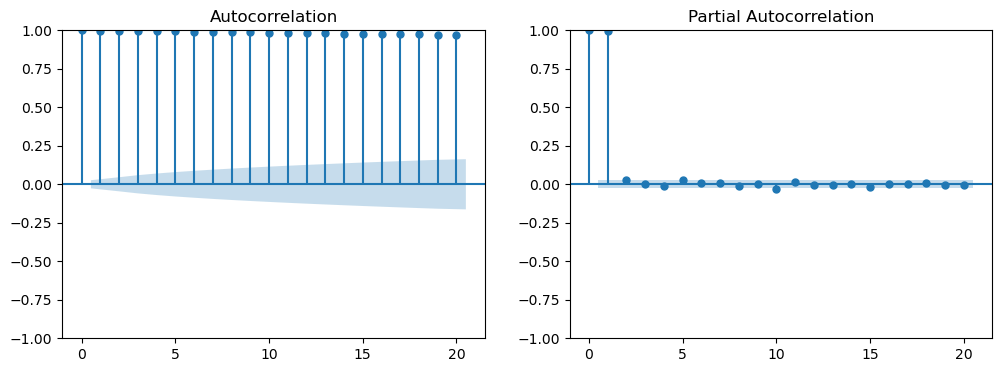

In [18]:
# Plot ACF and PACF
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(df['Adj Close'], ax=ax1, lags=20)
plot_pacf(df['Adj Close'], ax=ax2, lags=20)
plt.show()

In [19]:
# Determine the test size
test_size = int(len(df) * 0.25)

# Split into training and test sets
train = df.iloc[:-test_size]
test = df.iloc[-test_size:]

In [20]:
# Fit ARIMA model with d=2
from statsmodels.tsa.arima.model import ARIMA
p, q = 1, 1  # Update with values from ACF/PACF plots
d = 2  # Use the determined number of differences
model = ARIMA(train['Adj Close'], order=(p, d, q))
fit_model = model.fit()

# Make forecasts
forecast = fit_model.get_forecast(steps=test_size)

# Get predicted values and confidence intervals
predicted_values = forecast.predicted_mean
conf_int = forecast.conf_int()

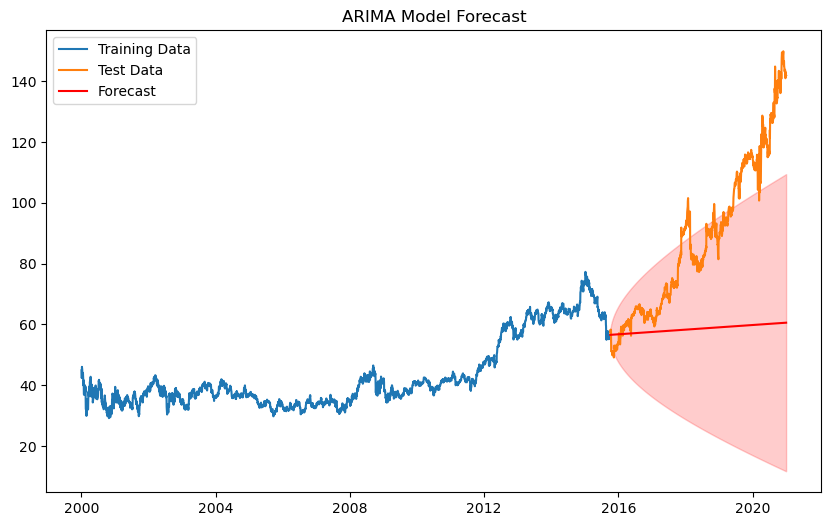

In [21]:
# Plot forecasts versus test data
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Adj Close'], label='Training Data')
plt.plot(test.index, test['Adj Close'], label='Test Data')
plt.plot(test.index, predicted_values, label='Forecast', color='red')
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='red', alpha=0.2)
plt.legend()
plt.title('ARIMA Model Forecast')
plt.show()

In [ ]:
import itertools

# Define the range of values for p, d, and q
p_values = range(0, 10)
d_values = range(0, 10)
q_values = range(0, 10)

# Initialize variables to store best parameters and minimum MAPE
best_params = (0, 0, 0)
min_mape = float('inf')

# Iterate through parameter combinations
for p, d, q in itertools.product(p_values, d_values, q_values):
    try:
        # Fit ARIMA model
        model = ARIMA(train['Adj Close'], order=(p, d, q))
        fit_model = model.fit()

        # Make forecasts
        forecast = fit_model.get_forecast(steps=test_size)
        predicted_values = forecast.predicted_mean

        # Calculate MAPE
        mape = mean_absolute_percentage_error(test['Adj Close'], predicted_values)

        # Update best parameters if current combination has lower MAPE
        if mape < min_mape:
            min_mape = mape
            best_params = (p, d, q)

    except Exception as e:
        # Handle any errors that may occur during model fitting
        print(f"Error for parameters ({p}, {d}, {q}): {e}")

# Display the best parameters
print("Best Parameters (p, d, q):", best_params)
print("Minimum MAPE:", min_mape)

In [22]:
# Calculate MAE and MAPE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
mae = mean_absolute_error(test['Adj Close'], predicted_values)
mape = mean_absolute_percentage_error(test['Adj Close'], predicted_values)

# Display metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)


Mean Absolute Error (MAE): 30.419388082732965
Mean Absolute Percentage Error (MAPE): 0.2962887505533949


In [23]:
# Tuning Model
best_p, best_d, best_q = (1, 3, 4)
final_model = ARIMA(train['Adj Close'], order=(best_p, best_d, best_q))
final_fit_model = final_model.fit()

# Make forecasts with the final model
final_forecast = final_fit_model.get_forecast(steps=test_size)
final_predicted_values = final_forecast.predicted_mean

# Calculate MAE and MAPE for the final model
final_mae = mean_absolute_error(test['Adj Close'], final_predicted_values)
final_mape = mean_absolute_percentage_error(test['Adj Close'], final_predicted_values)

# Display metrics for the final model
print("Final Model Metrics:")
print("Final Mean Absolute Error (MAE):", final_mae)
print("Final Mean Absolute Percentage Error (MAPE):", final_mape)

C:\Users\James\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Final Model Metrics:
Final Mean Absolute Error (MAE): 19.628704058929248
Final Mean Absolute Percentage Error (MAPE): 0.18738926516253213
